## 1- importer les bibliothéques

In [1]:
import os
from PIL import Image
import numpy as np 
import pandas as pd
from skimage.io import imread
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import make_scorer, recall_score, precision_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation, BatchNormalization
from keras.backend import dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.optimizers import Adam
from sklearn.metrics import classification_report


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 2- fixer les path des données augmenter 

In [2]:
sj_fliped='/kaggle/input/sjdata/DATA_(512,512)/augmented_data/sj_aug/sj_fliped'
sj_zoom='/kaggle/input/sjdata/DATA_(512,512)/augmented_data/sj_aug/sj_zoom'
sj_rotation='/kaggle/input/sjdata/DATA_(512,512)/augmented_data/sj_aug/sj_rotation'
sj_translation='/kaggle/input/sjdata/DATA_(512,512)/augmented_data/sj_aug/sj_translation'
sj_distortion='/kaggle/input/sjdata/DATA_(512,512)/augmented_data/sj_aug/sj_distortion'
sj_rot_trans_flip='/kaggle/input/sjdata/DATA_(512,512)/augmented_data/sj_aug/sj_fliped_rotation_translation'
sj_flip_distortion='/kaggle/input/sjdata/DATA_(512,512)/augmented_data/sj_aug/sj_fliped_distortion'
sj_rot_tran='/kaggle/input/sjdata/DATA_(512,512)/augmented_data/sj_aug/sj_rotation_translation'

nsj_fliped='/kaggle/input/sjdata/DATA_(512,512)/augmented_data/nsj_aug/nsj_fliped'
nsj_zoom='/kaggle/input/sjdata/DATA_(512,512)/augmented_data/nsj_aug/nsj_zoom'
nsj_rotation='/kaggle/input/sjdata/DATA_(512,512)/augmented_data/nsj_aug/nsj_rotation'
nsj_translation='/kaggle/input/sjdata/DATA_(512,512)/augmented_data/nsj_aug/nsj_translation'
nsj_distortion='/kaggle/input/sjdata/DATA_(512,512)/augmented_data/nsj_aug/nsj_distortion'
nsj_rot_trans_flip='/kaggle/input/sjdata/DATA_(512,512)/augmented_data/nsj_aug/nsj_fliped_rotation_translation'
nsj_flip_distortion='/kaggle/input/sjdata/DATA_(512,512)/augmented_data/nsj_aug/nsj_fliped_distortion'
nsj_rot_tran='/kaggle/input/sjdata/DATA_(512,512)/augmented_data/nsj_aug/nsj_rotation_translation'

In [3]:
sj_path='/kaggle/input/sjdata/DATA_(512,512)/sj_data'
nsj_path='/kaggle/input/sjdata/DATA_(512,512)/nsj_data'

## Mise en Forme des images

In [4]:

def mise_tenseur (path, nl, nc,pl):
    images_liste = os.listdir(path)
    images_liste.sort()
    Nb_images = len(images_liste)
    tenseur = np.empty((Nb_images, nl, nc, pl), dtype=np.uint8)
    k = 0
    for im in images_liste:
       
        img = imread(path+'/'+im)
        tenseur[k, :, :, 0] = img
        k +=1
    return(tenseur)

In [5]:
sj_data = []
sj_data.extend(mise_tenseur(sj_rotation,512,512,1))
sj_data.extend(mise_tenseur(sj_fliped, 512,512,1))
sj_data.extend(mise_tenseur(sj_zoom,512,512,1))
sj_data.extend(mise_tenseur(sj_translation,512,512,1))
sj_data.extend(mise_tenseur(sj_distortion,512,512,1))
sj_data.extend(mise_tenseur(sj_rot_trans_flip,512,512,1))
sj_data.extend(mise_tenseur(sj_flip_distortion,512,512,1))
sj_data.extend(mise_tenseur(sj_path,512,512,1))

In [6]:
nsj_data = []
nsj_data.extend(mise_tenseur(nsj_zoom,512,512,1))
nsj_data.extend(mise_tenseur(nsj_fliped,512,512,1))
nsj_data.extend(mise_tenseur(nsj_translation,512,512,1))
nsj_data.extend(mise_tenseur(nsj_distortion,512,512,1))
nsj_data.extend(mise_tenseur(nsj_rot_trans_flip,512,512,1))
nsj_data.extend(mise_tenseur(nsj_flip_distortion,512,512,1))
nsj_data.extend(mise_tenseur(nsj_rotation,512,512,1))
nsj_data.extend(mise_tenseur(nsj_path,512,512,1))

In [7]:
labels1 = [0] * len(nsj_data)  # labels pour la première classe (0)
labels2 = [1] * len(sj_data)  # labels pour la deuxième classe (1)

# Fusionner les données et les labels en un seul tableau multidimensionnel
data = np.concatenate([nsj_data, sj_data])
print(len(data))
labels = np.concatenate([labels1, labels2])
len(labels)


3600


3600

In [8]:
# Split the data into training and temporary sets
x_train, temp_data, y_train, temp_labels = train_test_split(data, labels, test_size=0.4,random_state=42)

# Split the temporary data into validation and test sets
x_val, x_test, y_val, y_test= train_test_split(temp_data, temp_labels, test_size=0.5,random_state=42)

In [9]:
# normaliser les données 
x_train = x_train.reshape(x_train.shape[0], 512,512, 1).astype('float32') / 255
x_test = x_test.reshape(x_test.shape[0], 512,512, 1).astype('float32') / 255
x_val = x_val.reshape(x_test.shape[0], 512,512, 1).astype('float32') / 255

In [10]:
model = Sequential()
model.add(Conv2D(32,(11,11),activation='relu', input_shape = (512,512,1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, kernel_size = (7,7),activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, kernel_size = (7,7),activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(16, kernel_size = (7,7),activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(16, kernel_size = (7,7),activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1,activation='sigmoid'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 502, 502, 32)      3904      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 251, 251, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 245, 245, 32)      50208     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 122, 122, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 116, 116, 32)      50208     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 58, 58, 32)       0

In [11]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])



In [12]:
H2 = model.fit(x_train, y_train, validation_data= (x_val, y_val), epochs=30, batch_size=32)

Epoch 1/30
68/68 [==============================] - 20s 177ms/step - loss: 0.6687 - accuracy: 0.5907 - val_loss: 0.6267 - val_accuracy: 0.6583
Epoch 2/30
68/68 [==============================] - 9s 138ms/step - loss: 0.5533 - accuracy: 0.7153 - val_loss: 0.5384 - val_accuracy: 0.7069
Epoch 3/30
68/68 [==============================] - 9s 137ms/step - loss: 0.4606 - accuracy: 0.7699 - val_loss: 0.4398 - val_accuracy: 0.7875
Epoch 4/30
68/68 [==============================] - 9s 137ms/step - loss: 0.4014 - accuracy: 0.8074 - val_loss: 0.5728 - val_accuracy: 0.7042
Epoch 5/30
68/68 [==============================] - 9s 138ms/step - loss: 0.2982 - accuracy: 0.8616 - val_loss: 0.2439 - val_accuracy: 0.8875
Epoch 6/30
68/68 [==============================] - 9s 135ms/step - loss: 0.1825 - accuracy: 0.9264 - val_loss: 0.1579 - val_accuracy: 0.9375
Epoch 7/30
68/68 [==============================] - 9s 136ms/step - loss: 0.1547 - accuracy: 0.9375 - val_loss: 0.1055 - val_accuracy: 0.9597
Epoch

# evaluation : train

23/23 [==============================] - 1s 47ms/step


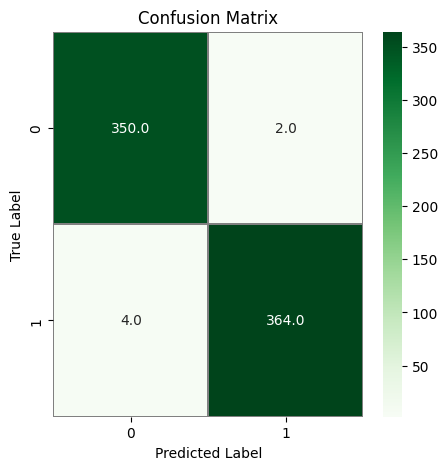

[[350   2]
 [  4 364]]


In [13]:
import seaborn as sns
# Générer des prédictions sur l'ensemble de test
y_pred = model.predict(x_val)
y_pred_classes = np.where(y_pred>0.5,1.,0)

# Calculer la matrice de confusion
cm = confusion_matrix(y_true=y_val, y_pred=y_pred_classes)
f,ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
print(cm)

In [14]:
print(classification_report(y_val, y_pred_classes))



              precision    recall  f1-score   support

           0       0.99      0.99      0.99       352
           1       0.99      0.99      0.99       368

    accuracy                           0.99       720
   macro avg       0.99      0.99      0.99       720
weighted avg       0.99      0.99      0.99       720



In [15]:
# Calculez la sensibilité, la spécificité, le FPR et le FNR à partir de la matrice de confusion
TN, FP, FN, TP = cm.ravel()
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)

# Calculez le LR+ et le LR- à partir de la sensibilité et de la spécificité
lr_plus = sensitivity / (1 - specificity)
lr_minus = (1 - sensitivity) / specificity

# Afficher les résultats
print("Matrice de confusion : ")
print(cm)
print("Sensibilité (TPR) : ", sensitivity)
print("Spécificité (TNR) : ", specificity)
print("Faux positifs (FPR) : ", FPR)
print("Faux négatifs (FNR) : ", FNR)
print("Rapport de vraisemblance positive (LR+) : ", lr_plus)
print("Rapport de vraisemblance négative (LR-) : ", lr_minus)

Matrice de confusion : 
[[350   2]
 [  4 364]]
Sensibilité (TPR) :  0.9891304347826086
Spécificité (TNR) :  0.9943181818181818
Faux positifs (FPR) :  0.005681818181818182
Faux négatifs (FNR) :  0.010869565217391304
Rapport de vraisemblance positive (LR+) :  174.08695652173756
Rapport de vraisemblance négative (LR-) :  0.01093167701863359


# evaluation : test

23/23 [==============================] - 1s 47ms/step


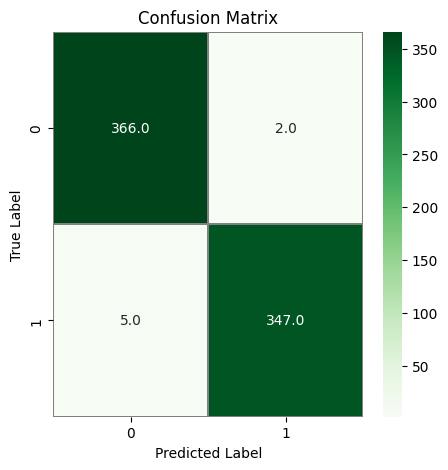

[[366   2]
 [  5 347]]


In [16]:
y_pred2 = model.predict(x_test)
y_pred_classes2 = np.where(y_pred2>0.5,1.,0)

# Calculer la matrice de confusion
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_classes2)
f,ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
print(cm)

In [17]:
model.save('ModelSjogrenn.h5') 

In [18]:
np.save("x_test",x_test)
np.save("y_test",y_test)

In [19]:
from IPython.display import FileLink
FileLink('x_test.npy')

/kaggle/working/x_test.npy